In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload

import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os

sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

import json

# 1. Read data from feather file

In [20]:
# # following is data from tej
# df_adjusted_price = pd.read_feather('data/tej_adjusted_price.feather')

# # following is data from cmoney
# df_price = pd.read_feather('data/cmoney_price.feather')
# df_company_info = pd.read_feather('data/cmoney_company_info.feather')

# ticker_list = np.sort(pd.unique(df_company_info['股票代號']))

# df_price = ut.cmoney_data_clean_up(df_price)
# df_price = deepcopy(df_price[df_price['股票代號'].isin(ticker_list)])

# df_adjusted_price = ut.tej_data_clean_up(df_adjusted_price)
# df_adjusted_price = deepcopy(df_adjusted_price[df_adjusted_price['股票代號'].isin(ticker_list)])

In [2]:
df_factor_all = pd.read_feather('data/df_factor_all.feather')
df_factor_all = df_factor_all[df_factor_all['date'] >= '2004-01-01']

df_factor_all.sort_values(['ticker', 'date'], inplace=True)
# get price 62 days later
df_factor_all['price_62d'] = df_factor_all.groupby('ticker', as_index=False, group_keys=False)['price'].shift(-62)
df_factor_all['y'] = df_factor_all['price_62d'] / df_factor_all['price'] - 1

# Calculate mean and standard deviation
df_factor_all['y_std'] = df_factor_all.groupby('date')['y'].transform('std')
df_factor_all['y_mean'] = df_factor_all.groupby('date')['y'].transform('mean')

# Create upper and lower bounds
df_factor_all['upper'] = df_factor_all['y_mean'] + 5 * df_factor_all['y_std']
df_factor_all['lower'] = df_factor_all['y_mean'] - 5 * df_factor_all['y_std']

# Truncate 'y' based on the bounds
df_factor_all['y_truncated'] = np.where(df_factor_all['y'] > df_factor_all['upper'], df_factor_all['upper'], 
                              np.where(df_factor_all['y'] < df_factor_all['lower'], df_factor_all['lower'], df_factor_all['y']))

# truncate the max value larger than 5 * std + mean to 5 * std + mean
# df_factor_all['y_truncated_max'] = df_factor_all.groupby('date', as_index=False, group_keys=False)['y'].apply(lambda x: np.where(x > x.mean() + 5 * x.std() , x.mean() + 5 * x.std() , x))['y']
# truncate the min value smaller than mean - 5 * std  to mean - 5 * std
# df_factor_all['y_truncated_max_min'] = df_factor_all.groupby('date', as_index=False, group_keys=False)['y_truncated_max'].apply(lambda x: np.where(x < x.mean() - 5 * x.std(), x.mean() - 5 * x.std(), x))['y_truncated_max']
# normalize the y_truncated

# group by date and ticker and normalize the y
df_factor_all['y_norm_truncated'] = df_factor_all.groupby('date', as_index=False, group_keys=False)['y_truncated'].apply(lambda x: (x - x.mean()) / x.std())

# replace inf with 9999
df_factor_all.replace([np.inf], 9999, inplace=True)
df_factor_all.replace([-np.inf], -9999, inplace=True)

# create a y_rank to rank the y_norm_truncated
df_factor_all['y_rank'] = df_factor_all.groupby('date', as_index=False, group_keys=False)['y_truncated'].rank(ascending=False, pct=True)

df_factor_all['sample_weight'] = 1
df_factor_all['sample_weight'] = df_factor_all['sample_weight'].mask(df_factor_all['y_rank']<=0.2, 3)
df_factor_all['sample_weight'] = df_factor_all['sample_weight'].mask(df_factor_all['y_rank']>=0.8, 3)
# name the folder by current date and time
# folder_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
folder_name = '20230724_091431'

# create a folder to store the model if not exist
if not os.path.exists(f'data/model/{folder_name}'):
    os.makedirs(f'data/model/{folder_name}')

df_factor_all.reset_index(drop=True, inplace=True)

# save the df_factor_all as a feather file
df_factor_all.to_feather(f'data/model/{folder_name}/df_factor_all_testing.feather')

<Axes: >

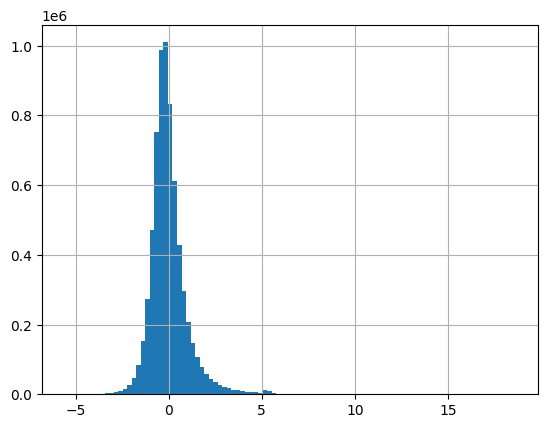

In [22]:
# plot the distribution of y
df_factor_all['y_norm_truncated'].hist(bins=100)

<Axes: >

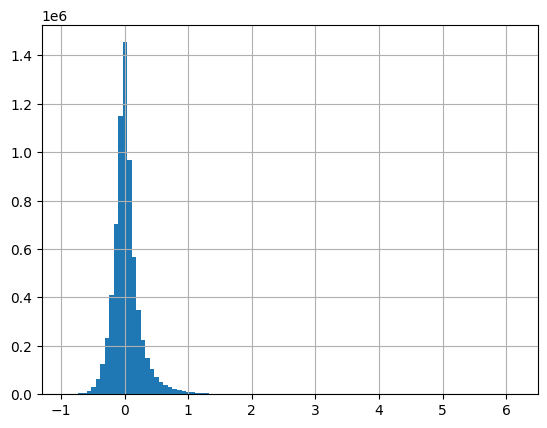

In [23]:
# plot the distribution of y
df_factor_all['y_truncated'].hist(bins=100)

In [24]:
def get_rebalance_date(date_list, start_date, end_date, freq='Q'):
    next_four_seasons = [start_date]
    rebalance_date = start_date
    i = 0
    while rebalance_date < end_date:
        if freq == 'Q':
            rebalance_date = start_date + pd.DateOffset(months=3 * (i + 1))
        elif freq == 'M':
            rebalance_date = start_date + pd.DateOffset(months=1 * (i + 1))
        elif freq == 'Y':
            rebalance_date = start_date + pd.DateOffset(years=1 * (i + 1))

        # check if rebalance_date is in date_list
        if rebalance_date in date_list:
            next_four_seasons.append(rebalance_date)
        else:
            # if not, find the next date in date_list
            for date in date_list:
                if date > rebalance_date:
                    # chang np.datetime64 to pd.Timestamp
                    rebalance_date = pd.Timestamp(date)
                    next_four_seasons.append(rebalance_date)
                    break
        i += 1
    return next_four_seasons

In [25]:
date_list = np.sort(pd.unique(df_factor_all['date']))

In [26]:
rebalance_date_lst = get_rebalance_date(date_list, pd.to_datetime('2004-02-25'), pd.to_datetime('2023-5-25'), freq='Q')

In [27]:
factor_columns = df_factor_all.columns.tolist()
factor_columns.remove('date')
factor_columns.remove('ticker')
factor_columns.remove('price')
factor_columns.remove('y')
factor_columns.remove('y_std')
factor_columns.remove('y_mean')
factor_columns.remove('upper')
factor_columns.remove('lower')
factor_columns.remove('price_62d')
factor_columns.remove('y_truncated')
factor_columns.remove('y_norm_truncated')
factor_columns.remove('y_rank')
factor_columns.remove('sample_weight')
factor_columns.remove('ppe_qoq')
factor_columns.remove('ppe_yoy')
factor_columns.remove('excess_return')
factor_columns.remove('market_cap')
print(factor_columns)

['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [28]:
target_cols = ['y_norm_truncated']
df_factor_all = df_factor_all.dropna(subset=factor_columns + target_cols, how='any')

In [30]:
start_index = 4

print(rebalance_date_lst[start_index])

2005-02-25 00:00:00


In [31]:
# name the folder by current date and time
# folder_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

model_save_path = f'models/{folder_name}'

# create a folder to save model
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

total = len(rebalance_date_lst) - start_index  # Total number of iterations


for i in range(start_index, len(rebalance_date_lst)):
    # expanding window
    train_date = rebalance_date_lst[0:i]
    rebalance_date = rebalance_date_lst[i]

    # data valid date = rebalance_date - 62 days
    data_valid_date = rebalance_date - pd.DateOffset(days=62)

    # remove date in train_date if date > data_valid_date
    valid_train_date = [date for date in train_date if date <= data_valid_date]



    # 訓練股票
    param_search = dict(
        learning_rate=[0.01, 0.05, 0.1],
        max_depth=[3, 5, 7],
        n_estimators=[5, 10, 50, 100, 200],
    )

    df_factor_all_train = df_factor_all[df_factor_all['date'].isin(train_date)]
    
    sample_weight = df_factor_all_train['sample_weight']

    fit_params={'sample_weight':sample_weight}
    
    model_stock = XGBRegressor()
    gscv = GridSearchCV(
        model_stock, param_search, refit=True, scoring="neg_root_mean_squared_error"
    )

    gscv.fit(df_factor_all_train[factor_columns], df_factor_all_train[target_cols], **fit_params)
    # timestamp to string format for saving model
    rebalance_date = rebalance_date.strftime("%Y%m%d")
    gscv.best_estimator_.save_model(f"{model_save_path}/{rebalance_date}.json")

    # Update Progress Bar
    print_progress_bar(i-start_index+1, total, prefix = 'Progress:', suffix = f'Complete. Current train data length: {len(df_factor_all_train)}', length = 50)


KeyboardInterrupt: 

In [32]:
# string the rebalance_date_lst for saving json
rebalance_date_lst_str = [date.strftime("%Y%m%d") for date in rebalance_date_lst]

In [34]:
# save the setting as a json file
with open(f'data/model/{folder_name}/setting.json', 'w') as f:
    json.dump({
        'start_index': start_index,
        'rebalance_date_lst': rebalance_date_lst_str,
        'factor_columns': factor_columns,
        'target_cols': target_cols,
        'model_save_path': model_save_path,
        # also the param_search
        'param_search': param_search,
        'fit_params': '<0.2, >0.8 sample_weight = 3, else 1'
    }, f)

In [35]:
# reset_index for df_factor_all
df_factor_all = df_factor_all.reset_index(drop=True)

# save the df_factor_all as a feather file
df_factor_all.to_feather(f'data/model/{folder_name}/df_factor_all.feather')